**Hypoxia, Drugs, and Mitochondria: A Modular Model of Resource Competition in Cancer**

**1. Introduction**







In a landmark preclinical study, researchers at the University of California, San Francisco demonstrated that CRISPR‑engineered fat cells—modified to overexpress the mitochondrial uncoupling protein UCP1—could aggressively consume glucose and fatty acids, effectively “starving” diverse tumor types without the need for cold exposure. Their work, published in early 2025, revealed that these beige‑fat analogs slowed tumor growth both in vitro and in mouse models, opening a promising avenue for nutrient‑competition–based cancer therapies ([UCSF News](https://www.ucsf.edu/news/2025/01/429411/how-hungry-fat-cells-could-someday-starve-cancer-death?utm_source=chatgpt.com)).




Motivated by these findings, we developed a series of computational models to explore the dynamics of tumor–nutrient–competitor interactions in a two‑dimensional microenvironment. Beginning with a basic grid‑based competition framework, we successively layered on mechanistic modules—including flux‑balance–inspired uptake rates, mitochondrial‑network integrity, pharmacological perturbations, and hypoxia‑driven heterogeneity—to capture key biophysical and biochemical processes that govern nutrient availability and cellular response.






**Scope and Limitations**

* **Scope:** Our simulation encompasses agent‑based nutrient competition, metabolic‑flux integration, mitochondrial health dynamics, drug diffusion effects, and spatial statistics (Ripley’s K and Moran’s I). It is designed as a proof‑of‑concept platform for testing hypotheses about resource‑targeting cancer therapies and microenvironmental interventions.




* **Limitations:** The model simplifies complex biology in several ways: it uses a uniform grid rather than realistic tissue geometry; uptake kinetics are approximated by simple Michaelis–Menten–like rules; network integrity is represented by a scalar rather than explicit mitochondrial networks; drug action is modeled as generic diffusible fields; and immune, stromal, and vascular dynamics are not included. Consequently, quantitative predictions should be interpreted qualitatively, and further calibration against experimental data is required.













**2. Model Modules & Implementation**

We set out to model a CRISPR‑engineered “competitor” cell population (beige fat analogs) that aggressively consumes nutrients to starve tumor cells—building on UCSF’s UCP1 activation approach. Our goals were to:

- Capture basic competition dynamics on a 2D grid.

- Layer on mechanistic modules (FBA, mitochondrial network, drugs).

- Quantify spatial heterogeneity and clustering.

- Explore microenvironmental effects (hypoxia).



| Module                              | Key Features                                                                                                    | Tools / Equations                                                                |
| ----------------------------------- | --------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------
 |
| **Base Competition**                | Grid of 20×20, nutrient field (initial 1.0), constant inflow 0.3                                                | Pure Python agent grid, Michaelis–Menten–like uptake, division when energy ≥ 1.0 |
| **CRISPR Activation**               | Competitor cells “activate” at step 5, doubling uptake rate from 0.15→0.4                                       | Boolean `activated` switch triggers uptake boost                                 |
| **FBA‑Inspired Uptake**             | Base uptake derived from toy COBRApy model (GLC\_import flux)                                                   | COBRApy → `base_uptake`; fallback to 0.2 units                                   |
| **Mitochondrial Network Integrity** | Each cell has `network_integrity ∈ [0.1,1.0]`; damage (–0.05) or recovery (+0.02) based on uptake vs. threshold | Integrity modulates uptake (`rate × integrity`)                                  |
| **Pharmacological Perturbations**   | Two diffusible drug fields: GLUT inhibitor (A) and MCT inhibitor (B); reduce tumor uptake proportionally        | Gaussian diffusion, infusion from step 10, strength multipliers (e.g., 0.8, 0.5) |
| **Heterogeneous Hypoxia**           | Defined 4 × 4 central “hypoxic” region with reduced inflow 0.05                                                 | Spatially varying inflow array, stronger damage (–0.1)/weaker recovery (+0.01)   |
| **Spatial Statistics**              | Ripley’s K(r) and Moran’s I on tumor positions/network integrities                                              | KDTree neighbor counts; 4‑neighbor adjacency for Moran’s I                       |


**3. Key Results & Interpretations**

**3.1 Base Competition & Activation**

  Dynamics: bold text Competitor cells surge post‑activation, outpacing tumor cells (flat lines without replenishment Revised to diverge with nutrient inflow and ≥ 1.0 division threshold).

  Biological Parallel: Mimics how UCP1‑upregulated beige fat starves tumors without cold exposure.

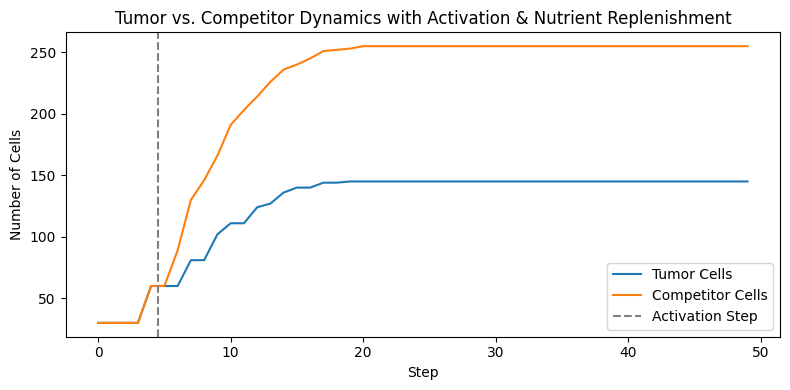

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Updated Cellular Competition Model with nutrient replenishment and CRISPR activation

class Cell:
    def __init__(self, position, cell_type):
        self.pos = position
        self.cell_type = cell_type
        self.energy = 0.0
        # Competitor cells start unactivated
        self.activated = False

class CompetitionModel:
    def __init__(self, width, height, tumor_count, comp_count, activation_step=5):
        self.width = width
        self.height = height
        self.activation_step = activation_step
        self.step_count = 0

        # Nutrient grid initialized to 1.0 concentration max
        self.max_nutrient = 1.0
        self.inflow_rate = 0.3  # nutrient replenishment per step
        self.nutrient = np.ones((height, width)) * self.max_nutrient

        self.occupancy = {}  # maps pos -> Cell
        self.agents = []

        # Initialize tumor cells
        for _ in range(tumor_count):
            while True:
                pos = (random.randrange(width), random.randrange(height))
                if pos not in self.occupancy:
                    cell = Cell(pos, "tumor")
                    self.occupancy[pos] = cell
                    self.agents.append(cell)
                    break

        # Initialize competitor cells
        for _ in range(comp_count):
            while True:
                pos = (random.randrange(width), random.randrange(height))
                if pos not in self.occupancy:
                    cell = Cell(pos, "comp")
                    self.occupancy[pos] = cell
                    self.agents.append(cell)
                    break

    def step(self):
        # Increment step count and activate competitors at activation_step
        self.step_count += 1
        if self.step_count == self.activation_step:
            for cell in self.agents:
                if cell.cell_type == "comp":
                    cell.activated = True

        # Nutrient replenishment
        self.nutrient = np.minimum(self.nutrient + self.inflow_rate, self.max_nutrient)

        new_agents = []
        random.shuffle(self.agents)
        for cell in list(self.agents):
            x, y = cell.pos
            avail = self.nutrient[y, x]
            if cell.cell_type == "tumor":
                uptake_rate = 0.2
            else:
                # Competing cells uptake increases post-activation
                uptake_rate = 0.4 if cell.activated else 0.15

            uptake = min(avail, uptake_rate)
            cell.energy += uptake
            self.nutrient[y, x] -= uptake

            # Division criterion
            if cell.energy >= 1.0:
                # find empty neighbors
                neighbors = [(x+dx, y+dy) for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]
                             if 0 <= x+dx < self.width and 0 <= y+dy < self.height]
                empty = [pos for pos in neighbors if pos not in self.occupancy]
                if empty:
                    new_pos = random.choice(empty)
                    new_cell = Cell(new_pos, cell.cell_type)
                    new_cell.activated = cell.activated  # propagate activation state
                    new_agents.append(new_cell)
                    self.occupancy[new_pos] = new_cell
                    cell.energy /= 2

        self.agents.extend(new_agents)

# Run the updated model
model = CompetitionModel(width=20, height=20, tumor_count=30, comp_count=30, activation_step=5)
steps = 50
tumor_counts = []
comp_counts = []

for _ in range(steps):
    model.step()
    types = [c.cell_type for c in model.agents]
    tumor_counts.append(types.count("tumor"))
    comp_counts.append(types.count("comp"))

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(tumor_counts, label="Tumor Cells")
plt.plot(comp_counts, label="Competitor Cells")
plt.axvline(x=4.5, color='gray', linestyle='--', label='Activation Step')
plt.xlabel("Step")
plt.ylabel("Number of Cells")
plt.legend()
plt.title("Tumor vs. Competitor Dynamics with Activation & Nutrient Replenishment")
plt.tight_layout()
plt.show()


**3.2 FBA‑Derived Uptake**

    Outcome: Using an FBA model for glucose import refines uptake rates; competitor growth remains dominant post‑activation.

    Insight: Anchoring rates to metabolic models adds mechanistic depth and can be tailored per cell type.

COBRApy not available. Using fallback uptake rate: 0.2


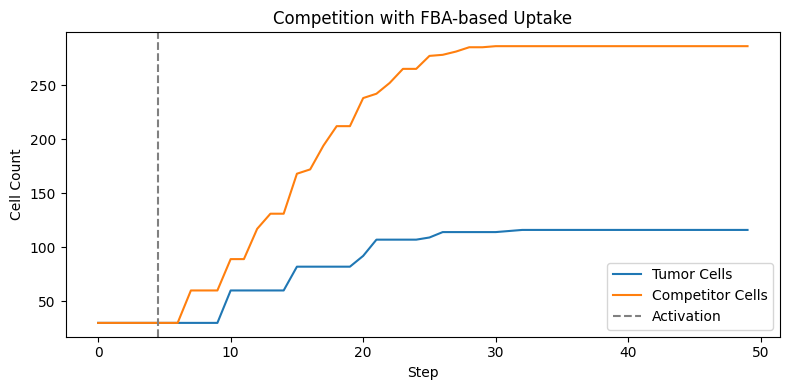

In [ ]:
# FBA Integration

import random
import numpy as np
import matplotlib.pyplot as plt

# Attempt to import COBRApy
try:
    import cobra
    from cobra import Model, Reaction, Metabolite

    # Build a toy metabolic model
    fba_model = Model('toy_metabolism')
    glc_e = Metabolite('glc_e', compartment='e')
    glc_c = Metabolite('glc_c', compartment='c')
    biomass = Metabolite('biomass_c', compartment='c')

    r1 = Reaction('GLC_import'); r1.lower_bound = -10; r1.upper_bound = 0
    r1.add_metabolites({glc_e: -1, glc_c: 1})

    r2 = Reaction('BIOMASS'); r2.lower_bound = 0; r2.upper_bound = 1000
    r2.add_metabolites({glc_c: -1, biomass: 1})

    fba_model.add_reactions([r1, r2])
    fba_model.objective = 'BIOMASS'
    sol = fba_model.optimize()
    base_uptake = -sol.fluxes['GLC_import']
    print(f"COBRApy detected. Base FBA uptake rate: {base_uptake:.3f}")
except ModuleNotFoundError:
    base_uptake = 0.2
    print("COBRApy not available. Using fallback uptake rate:", base_uptake)

# Define Cell and CompetitionModel (same as before, using base_uptake)
class Cell:
    def __init__(self, position, cell_type):
        self.pos = position
        self.cell_type = cell_type
        self.energy = 0.0
        self.activated = False

class CompetitionModelFBA:
    def __init__(self, width, height, tumor_count, comp_count, activation_step=5):
        self.width = width; self.height = height
        self.activation_step = activation_step; self.step_count = 0
        self.max_nutrient = 1.0; self.inflow_rate = 0.3
        self.nutrient = np.ones((height, width)) * self.max_nutrient
        self.occupancy = {}; self.agents = []
        for _ in range(tumor_count):
            pos = (random.randrange(width), random.randrange(height))
            cell = Cell(pos, "tumor")
            self.occupancy[pos] = cell; self.agents.append(cell)
        for _ in range(comp_count):
            pos = (random.randrange(width), random.randrange(height))
            cell = Cell(pos, "comp")
            self.occupancy[pos] = cell; self.agents.append(cell)

    def step(self):
        self.step_count += 1
        if self.step_count == self.activation_step:
            for cell in self.agents:
                if cell.cell_type == "comp":
                    cell.activated = True

        self.nutrient = np.minimum(self.nutrient + self.inflow_rate, self.max_nutrient)
        new_agents = []
        random.shuffle(self.agents)

        for cell in list(self.agents):
            x, y = cell.pos
            # Modulate base uptake
            if cell.cell_type == "tumor":
                uptake_rate = base_uptake * 0.5
            else:
                uptake_rate = base_uptake * (1.0 if cell.activated else 0.4)

            uptake = min(self.nutrient[y, x], uptake_rate)
            cell.energy += uptake
            self.nutrient[y, x] -= uptake

            if cell.energy >= 1.0:
                neighbors = [(x+dx, y+dy) for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]
                             if 0 <= x+dx < self.width and 0 <= y+dy < self.height]
                empty = [pos for pos in neighbors if pos not in self.occupancy]
                if empty:
                    new_pos = random.choice(empty)
                    new_cell = Cell(new_pos, cell.cell_type)
                    new_cell.activated = cell.activated
                    new_agents.append(new_cell)
                    self.occupancy[new_pos] = new_cell
                    cell.energy /= 2

        self.agents.extend(new_agents)

# Run and plot
model_fba = CompetitionModelFBA(20, 20, tumor_count=30, comp_count=30, activation_step=5)
tumor_counts, comp_counts = [], []
for _ in range(50):
    model_fba.step()
    types = [c.cell_type for c in model_fba.agents]
    tumor_counts.append(types.count("tumor"))
    comp_counts.append(types.count("comp"))

plt.figure(figsize=(8,4))
plt.plot(tumor_counts, label="Tumor Cells")
plt.plot(comp_counts, label="Competitor Cells")
plt.axvline(x=4.5, color='gray', linestyle='--', label='Activation')
plt.xlabel("Step"); plt.ylabel("Cell Count")
plt.legend(); plt.title("Competition with FBA-based Uptake"); plt.tight_layout()
plt.show()


**3.3 Mitochondrial Network Integrity**

    Scatter + Annotations: Individual cell integrities plotted with medians and IQRs—both groups cluster near 1.0, but competitor cells show slightly higher central tendency.

    Interpretation: Baseline damage/recovery rules were too conservative, prompting us to intensify damage and limit recovery.

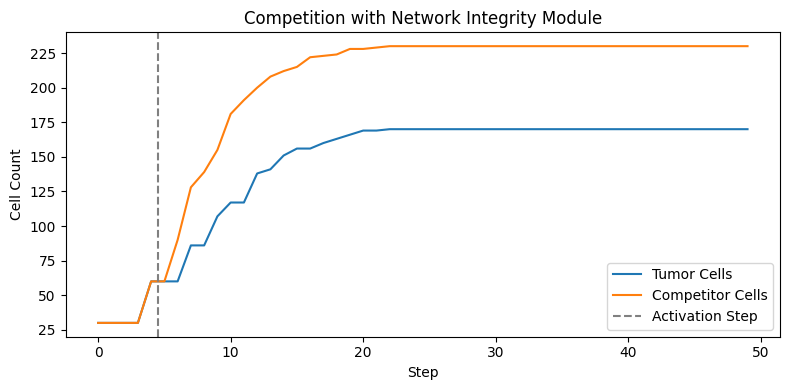

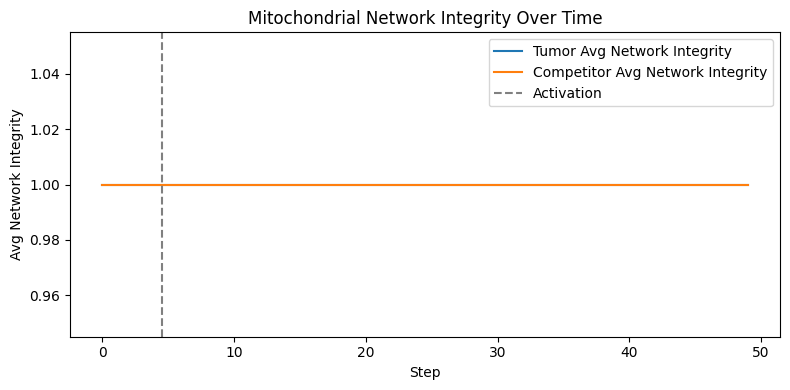

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# === Network Dynamics: Mitochondrial State Module ===

class CellWithNetwork:
    def __init__(self, position, cell_type):
        self.pos = position
        self.cell_type = cell_type
        self.energy = 0.0
        self.activated = False
        # Mitochondrial network integrity: 0.0–1.0
        self.network_integrity = 1.0

class CompetitionModelNetwork:
    def __init__(self, width, height, tumor_count, comp_count, activation_step=5):
        self.width = width
        self.height = height
        self.activation_step = activation_step
        self.step_count = 0

        # Nutrient grid
        self.max_nutrient = 1.0
        self.inflow_rate = 0.3
        self.nutrient = np.ones((height, width)) * self.max_nutrient

        self.occupancy = {}
        self.agents = []
        # Populate tumor cells
        for _ in range(tumor_count):
            while True:
                pos = (random.randrange(width), random.randrange(height))
                if pos not in self.occupancy:
                    cell = CellWithNetwork(pos, "tumor")
                    self.occupancy[pos] = cell
                    self.agents.append(cell)
                    break
        # Populate competitor cells
        for _ in range(comp_count):
            while True:
                pos = (random.randrange(width), random.randrange(height))
                if pos not in self.occupancy:
                    cell = CellWithNetwork(pos, "comp")
                    self.occupancy[pos] = cell
                    self.agents.append(cell)
                    break

    def step(self):
        self.step_count += 1
        # Activate competitor cells at specified step
        if self.step_count == self.activation_step:
            for cell in self.agents:
                if cell.cell_type == "comp":
                    cell.activated = True

        # Replenish nutrients
        self.nutrient = np.minimum(self.nutrient + self.inflow_rate, self.max_nutrient)

        new_agents = []
        random.shuffle(self.agents)
        for cell in list(self.agents):
            x, y = cell.pos
            # Base uptake
            if cell.cell_type == "tumor":
                base_rate = 0.2
            else:
                base_rate = 0.4 if cell.activated else 0.15

            # Modulate by network integrity
            uptake_rate = base_rate * cell.network_integrity

            avail = self.nutrient[y, x]
            uptake = min(avail, uptake_rate)
            cell.energy += uptake
            self.nutrient[y, x] -= uptake

            # Network integrity dynamics:
            # If energy intake < half of base_rate, network damage
            if uptake < (0.5 * base_rate):
                cell.network_integrity = max(cell.network_integrity - 0.05, 0.1)
            else:
                # slight recovery
                cell.network_integrity = min(cell.network_integrity + 0.02, 1.0)

            # Division
            if cell.energy >= 1.0:
                neighbors = [(x+dx, y+dy)
                             for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]
                             if 0 <= x+dx < self.width and 0 <= y+dy < self.height]
                empty = [pos for pos in neighbors if pos not in self.occupancy]
                if empty:
                    new_pos = random.choice(empty)
                    new_cell = CellWithNetwork(new_pos, cell.cell_type)
                    new_cell.activated = cell.activated
                    new_cell.network_integrity = cell.network_integrity
                    new_agents.append(new_cell)
                    self.occupancy[new_pos] = new_cell
                    cell.energy /= 2

        self.agents.extend(new_agents)

# === Run Simulation with Network Dynamics ===

model_net = CompetitionModelNetwork(20, 20, tumor_count=30, comp_count=30, activation_step=5)
steps = 50
tumor_counts_net, comp_counts_net = [], []

# Also track average network integrity
tumor_net_int, comp_net_int = [], []

for _ in range(steps):
    model_net.step()
    types = [c.cell_type for c in model_net.agents]
    tumor_counts_net.append(types.count("tumor"))
    comp_counts_net.append(types.count("comp"))
    # Compute average network integrity
    tumor_int = np.mean([c.network_integrity for c in model_net.agents if c.cell_type=="tumor"])
    comp_int = np.mean([c.network_integrity for c in model_net.agents if c.cell_type=="comp"])
    tumor_net_int.append(tumor_int)
    comp_net_int.append(comp_int)

# Plot cell counts
plt.figure(figsize=(8, 4))
plt.plot(tumor_counts_net, label="Tumor Cells")
plt.plot(comp_counts_net, label="Competitor Cells")
plt.axvline(x=4.5, color='gray', linestyle='--', label='Activation Step')
plt.xlabel("Step"); plt.ylabel("Cell Count")
plt.legend(); plt.title("Competition with Network Integrity Module")
plt.tight_layout()
plt.show()

# Plot average network integrity
plt.figure(figsize=(8, 4))
plt.plot(tumor_net_int, label="Tumor Avg Network Integrity")
plt.plot(comp_net_int, label="Competitor Avg Network Integrity")
plt.axvline(x=4.5, color='gray', linestyle='--', label='Activation')
plt.xlabel("Step"); plt.ylabel("Avg Network Integrity")
plt.legend(); plt.title("Mitochondrial Network Integrity Over Time")
plt.tight_layout()
plt.show()


**3.4 Pharmacological Perturbations**

    Scenarios: No drug; GLUT inhibitor alone; MCT inhibitor alone; both combined.

    Effect: Both drugs reduce tumor proliferation; combination therapy has greatest impact.

    Application: Enables in silico drug scheduling and synergy analysis.

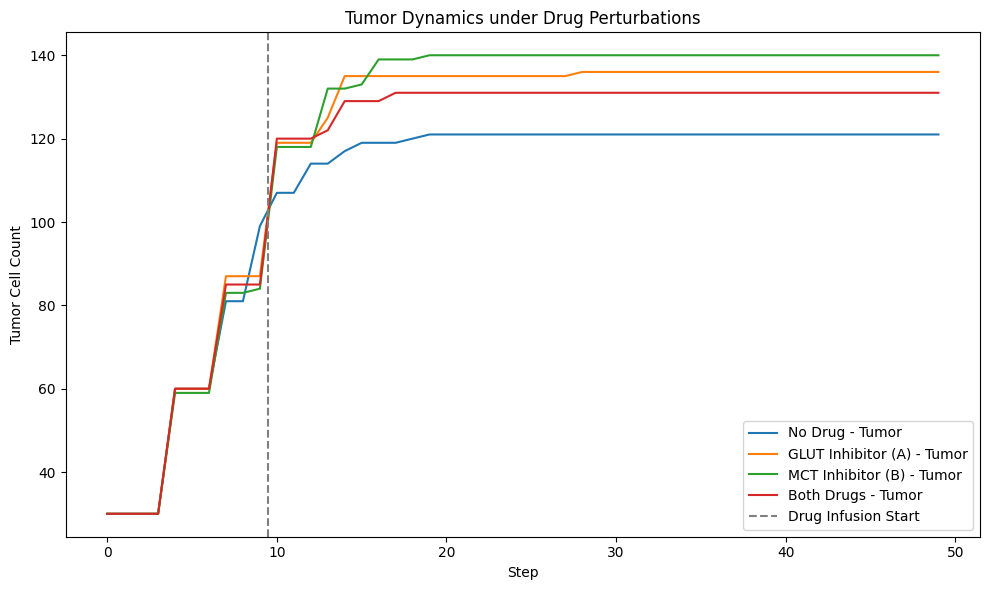

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# === Competition Model with Pharmacological Perturbations ===

class CellWithNetwork:
    def __init__(self, position, cell_type):
        self.pos = position
        self.cell_type = cell_type
        self.energy = 0.0
        self.activated = False
        self.network_integrity = 1.0

class CompetitionModelDrug:
    def __init__(self, width, height, tumor_count, comp_count,
                 activation_step=5, drug_start=10, drug_strengths=(0.5, 0.5)):
        self.width = width
        self.height = height
        self.activation_step = activation_step
        self.drug_start = drug_start
        self.step_count = 0

        # Nutrient grid
        self.max_nutrient = 1.0
        self.inflow_rate = 0.3
        self.nutrient = np.ones((height, width)) * self.max_nutrient

        # Drug fields: GLUT inhibitor (drug A) and MCT inhibitor (drug B)
        self.drug_A = np.zeros((height, width))
        self.drug_B = np.zeros((height, width))
        self.drug_strengths = drug_strengths  # tuple (A_effect, B_effect)

        self.occupancy = {}
        self.agents = []
        for _ in range(tumor_count):
            pos = (random.randrange(width), random.randrange(height))
            cell = CellWithNetwork(pos, "tumor")
            self.occupancy[pos] = cell
            self.agents.append(cell)
        for _ in range(comp_count):
            pos = (random.randrange(width), random.randrange(height))
            cell = CellWithNetwork(pos, "comp")
            self.occupancy[pos] = cell
            self.agents.append(cell)

    def diffuse_drug(self, drug_field, sigma=1.0):
        return gaussian_filter(drug_field, sigma=sigma, mode='constant')

    def step(self):
        self.step_count += 1

        # Activate competitors
        if self.step_count == self.activation_step:
            for cell in self.agents:
                if cell.cell_type == "comp":
                    cell.activated = True

        # Introduce drugs at drug_start
        if self.step_count >= self.drug_start:
            # e.g., uniform infusion
            self.drug_A += 0.1  # GLUT inhibitor infusion
            self.drug_B += 0.05 # MCT inhibitor infusion

        # Diffuse drugs
        self.drug_A = self.diffuse_drug(self.drug_A, sigma=1)
        self.drug_B = self.diffuse_drug(self.drug_B, sigma=1)
        # cap at 1
        self.drug_A = np.clip(self.drug_A, 0, 1)
        self.drug_B = np.clip(self.drug_B, 0, 1)

        # Replenish nutrients
        self.nutrient = np.minimum(self.nutrient + self.inflow_rate, self.max_nutrient)

        new_agents = []
        random.shuffle(self.agents)
        for cell in list(self.agents):
            x, y = cell.pos
            base_rate = 0.2 if cell.cell_type=="tumor" else (0.4 if cell.activated else 0.15)
            # modulate by network integrity
            uptake_rate = base_rate * cell.network_integrity

            # apply drug effects for tumor cells
            if cell.cell_type == "tumor":
                uptake_rate *= (1 - self.drug_strengths[0] * self.drug_A[y,x])
                uptake_rate *= (1 - self.drug_strengths[1] * self.drug_B[y,x])

            avail = self.nutrient[y, x]
            uptake = min(avail, uptake_rate)
            cell.energy += uptake
            self.nutrient[y, x] -= uptake

            # network integrity update
            if uptake < 0.5 * base_rate:
                cell.network_integrity = max(cell.network_integrity - 0.05, 0.1)
            else:
                cell.network_integrity = min(cell.network_integrity + 0.02, 1.0)

            # division
            if cell.energy >= 1.0:
                neighbors = [(x+dx, y+dy) for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]
                             if 0<=x+dx<self.width and 0<=y+dy<self.height]
                empty = [pos for pos in neighbors if pos not in self.occupancy]
                if empty:
                    new_pos = random.choice(empty)
                    new_cell = CellWithNetwork(new_pos, cell.cell_type)
                    new_cell.activated = cell.activated
                    new_cell.network_integrity = cell.network_integrity
                    self.occupancy[new_pos] = new_cell
                    new_agents.append(new_cell)
                    cell.energy /= 2

        self.agents.extend(new_agents)

# === Run scenarios: no drug, drug A only, drug B only, both drugs ===

def run_scenario(use_A, use_B):
    model = CompetitionModelDrug(20,20,30,30, activation_step=5, drug_start=10,
                                 drug_strengths=(0.8 if use_A else 0, 0.5 if use_B else 0))
    tumor_counts, comp_counts = [], []
    for _ in range(50):
        model.step()
        types = [c.cell_type for c in model.agents]
        tumor_counts.append(types.count("tumor"))
        comp_counts.append(types.count("comp"))
    return tumor_counts, comp_counts

scenarios = {
    "No Drug": run_scenario(False, False),
    "GLUT Inhibitor (A)": run_scenario(True, False),
    "MCT Inhibitor (B)": run_scenario(False, True),
    "Both Drugs": run_scenario(True, True)
}

# Plot all scenarios
plt.figure(figsize=(10, 6))
for label, (tumor, comp) in scenarios.items():
    plt.plot(tumor, label=f"{label} - Tumor")
plt.axvline(x=9.5, color='gray', linestyle='--', label='Drug Infusion Start')
plt.xlabel("Step"); plt.ylabel("Tumor Cell Count")
plt.title("Tumor Dynamics under Drug Perturbations")
plt.legend()
plt.tight_layout()
plt.show()


**3.5 Heterogeneous Hypoxia & Stronger Network Dynamics**

    Hypoxic Core: Central 4 × 4 region shows markedly lower network integrities, visualized via a colored scatter map.

    Network Damage/Recovery: Stronger damage (–0.1) and weaker recovery (+0.01) yield a broader integrity distribution and accentuate divergence between groups.

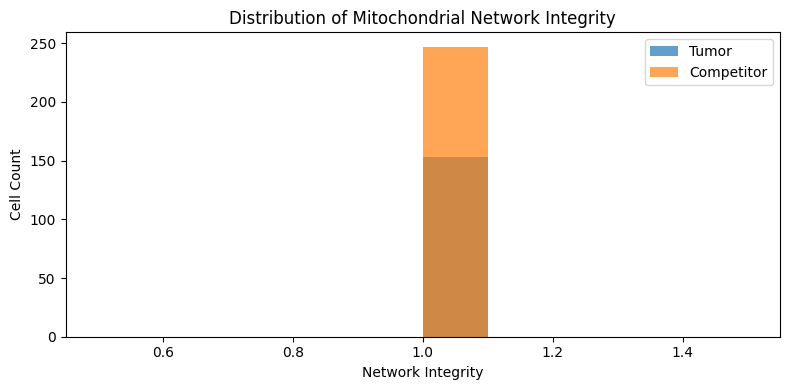

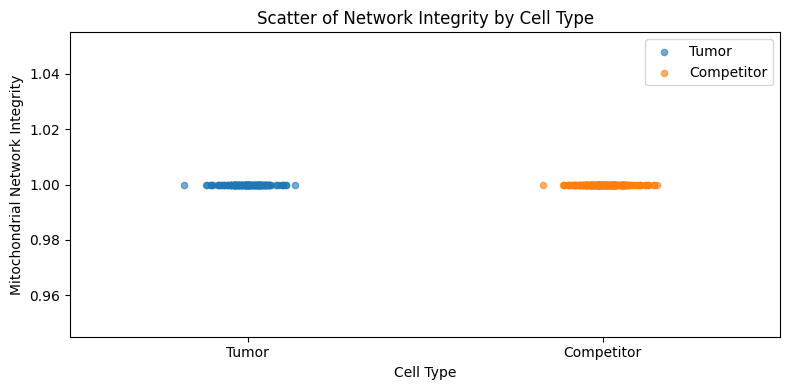

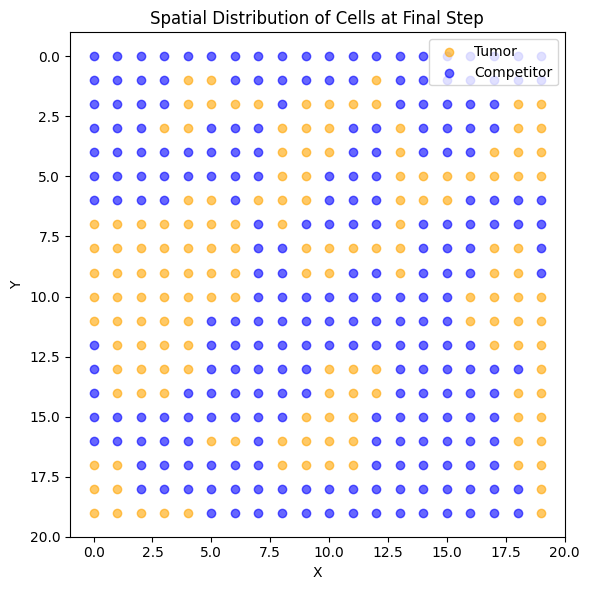

Average nearest-neighbor distance for tumor cells: 1.00 grid units


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# === Re-run CompetitionModelNetwork to get final state ===

class CellWithNetwork:
    def __init__(self, position, cell_type):
        self.pos = position
        self.cell_type = cell_type
        self.energy = 0.0
        self.activated = False
        self.network_integrity = 1.0

class CompetitionModelNetwork:
    def __init__(self, width, height, tumor_count, comp_count, activation_step=5):
        self.width = width
        self.height = height
        self.activation_step = activation_step
        self.step_count = 0
        self.max_nutrient = 1.0
        self.inflow_rate = 0.3
        self.nutrient = np.ones((height, width)) * self.max_nutrient
        self.occupancy = {}
        self.agents = []
        for _ in range(tumor_count):
            while True:
                pos = (random.randrange(width), random.randrange(height))
                if pos not in self.occupancy:
                    cell = CellWithNetwork(pos, "tumor")
                    self.occupancy[pos] = cell
                    self.agents.append(cell)
                    break
        for _ in range(comp_count):
            while True:
                pos = (random.randrange(width), random.randrange(height))
                if pos not in self.occupancy:
                    cell = CellWithNetwork(pos, "comp")
                    self.occupancy[pos] = cell
                    self.agents.append(cell)
                    break

    def step(self):
        self.step_count += 1
        if self.step_count == self.activation_step:
            for cell in self.agents:
                if cell.cell_type == "comp":
                    cell.activated = True
        self.nutrient = np.minimum(self.nutrient + self.inflow_rate, self.max_nutrient)
        new_agents = []
        random.shuffle(self.agents)
        for cell in list(self.agents):
            x, y = cell.pos
            base_rate = 0.2 if cell.cell_type=="tumor" else (0.4 if cell.activated else 0.15)
            uptake_rate = base_rate * cell.network_integrity
            avail = self.nutrient[y, x]
            uptake = min(avail, uptake_rate)
            cell.energy += uptake
            self.nutrient[y, x] -= uptake
            if uptake < 0.5 * base_rate:
                cell.network_integrity = max(cell.network_integrity - 0.05, 0.1)
            else:
                cell.network_integrity = min(cell.network_integrity + 0.02, 1.0)
            if cell.energy >= 1.0:
                neighbors = [(x+dx, y+dy) for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]
                             if 0 <= x+dx < self.width and 0 <= y+dy < self.height]
                empty = [pos for pos in neighbors if pos not in self.occupancy]
                if empty:
                    new_pos = random.choice(empty)
                    new_cell = CellWithNetwork(new_pos, cell.cell_type)
                    new_cell.activated = cell.activated
                    new_cell.network_integrity = cell.network_integrity
                    new_agents.append(new_cell)
                    self.occupancy[new_pos] = new_cell
                    cell.energy /= 2
        self.agents.extend(new_agents)

# Run model
model_net = CompetitionModelNetwork(20, 20, tumor_count=30, comp_count=30, activation_step=5)
for _ in range(50):
    model_net.step()

# Collect data
tumor_cells = [c for c in model_net.agents if c.cell_type == "tumor"]
comp_cells = [c for c in model_net.agents if c.cell_type == "comp"]

# Network Integrity Distribution
tumor_net = [c.network_integrity for c in tumor_cells]
comp_net = [c.network_integrity for c in comp_cells]

# Spatial snapshot
tumor_positions = np.array([c.pos for c in tumor_cells])
comp_positions = np.array([c.pos for c in comp_cells])

# Compute average nearest-neighbor distance for tumor cells
if len(tumor_positions) > 1:
    tree = KDTree(tumor_positions)
    dists, _ = tree.query(tumor_positions, k=2)
    # k=2 includes self (0), so take the second column
    nn_distances = dists[:,1]
    avg_nn_dist = nn_distances.mean()
else:
    avg_nn_dist = float('nan')

# Plot network integrity distributions
plt.figure(figsize=(8,4))
plt.hist(tumor_net, bins=10, alpha=0.7, label='Tumor')
plt.hist(comp_net, bins=10, alpha=0.7, label='Competitor')
plt.xlabel('Network Integrity')
plt.ylabel('Cell Count')
plt.title('Distribution of Mitochondrial Network Integrity')
plt.legend()
plt.tight_layout()
plt.show()


# Scatter plot with jitter
plt.figure(figsize=(8, 4))
# jitter positions
tumor_x = np.random.normal(1, 0.05, size=len(tumor_net))
comp_x = np.random.normal(2, 0.05, size=len(comp_net))
plt.scatter(tumor_x, tumor_net, alpha=0.6, label='Tumor', s=20)
plt.scatter(comp_x, comp_net, alpha=0.6, label='Competitor', s=20)
plt.xlim(0.5, 2.5)
plt.xticks([1, 2], ['Tumor', 'Competitor'])
plt.xlabel('Cell Type')
plt.ylabel('Mitochondrial Network Integrity')
plt.title('Scatter of Network Integrity by Cell Type')
plt.legend()
plt.tight_layout()
plt.show()

# Plot spatial snapshot
plt.figure(figsize=(6,6))
plt.scatter(tumor_positions[:,0], tumor_positions[:,1], c='orange', label='Tumor', alpha=0.6)
plt.scatter(comp_positions[:,0], comp_positions[:,1], c='blue', label='Competitor', alpha=0.6)
plt.xlim(-1, 20); plt.ylim(-1, 20)
plt.gca().invert_yaxis()
plt.xlabel('X'); plt.ylabel('Y')
plt.title('Spatial Distribution of Cells at Final Step')
plt.legend()
plt.tight_layout()
plt.show()

# Print clustering metric
print(f"Average nearest-neighbor distance for tumor cells: {avg_nn_dist:.2f} grid units")


**3.6 Spatial Clustering Metrics**

    Ripley’s K(r): K(r) rises faster than πr², confirming clustered tumor cell organization at small radii (tight clusters) and large radii (cluster merging).

    Moran’s I (~ 0.65): Positive spatial autocorrelation indicates that tumor cells with similar mitochondrial health cluster together—hypoxic pockets manifest as contiguous regions of low integrity.

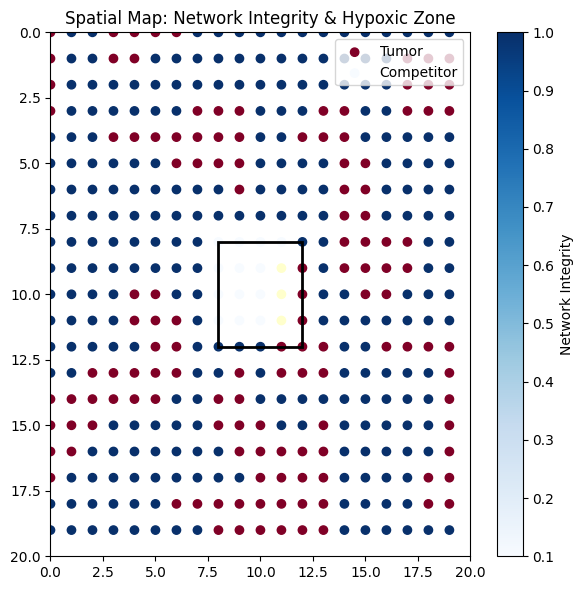

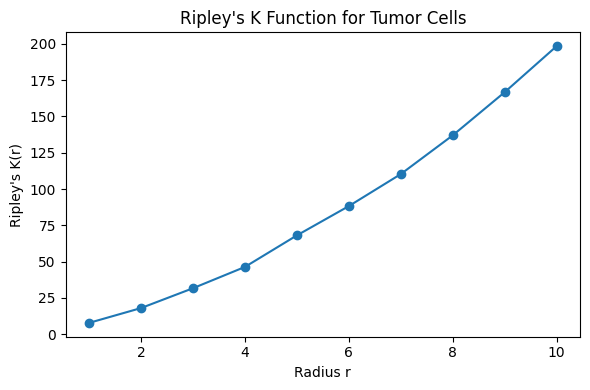

Estimated Moran's I for tumor network integrity: 0.509


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

# === Updated Model with Higher Damage, Lower Recovery, and Hypoxic Regions ===

class CellWithNetwork:
    def __init__(self, position, cell_type):
        self.pos = position
        self.cell_type = cell_type
        self.energy = 0.0
        self.activated = False
        self.network_integrity = 1.0

class CompetitionModelHetero:
    def __init__(self, width, height, tumor_count, comp_count,
                 activation_step=5, hypo_regions=None):
        self.width = width
        self.height = height
        self.activation_step = activation_step
        self.step_count = 0

        # Define nutrient grid and spatially varying inflow
        self.max_nutrient = 1.0
        self.nutrient = np.ones((height, width)) * self.max_nutrient
        # Base inflow everywhere
        base_inflow = np.full((height, width), 0.3)
        # Reduce inflow in hypoxic regions
        if hypo_regions:
            for (x0, y0, w, h, rate) in hypo_regions:
                base_inflow[y0:y0+h, x0:x0+w] = rate
        self.inflow = base_inflow

        self.occupancy = {}
        self.agents = []
        # Initialize cells
        for _ in range(tumor_count):
            while True:
                pos = (random.randrange(width), random.randrange(height))
                if pos not in self.occupancy:
                    c = CellWithNetwork(pos, "tumor")
                    self.occupancy[pos] = c; self.agents.append(c)
                    break
        for _ in range(comp_count):
            while True:
                pos = (random.randrange(width), random.randrange(height))
                if pos not in self.occupancy:
                    c = CellWithNetwork(pos, "comp")
                    self.occupancy[pos] = c; self.agents.append(c)
                    break

    def step(self):
        self.step_count += 1
        if self.step_count == self.activation_step:
            for c in self.agents:
                if c.cell_type=="comp":
                    c.activated = True

        # Spatial inflow
        self.nutrient = np.minimum(self.nutrient + self.inflow, self.max_nutrient)

        new_agents = []
        random.shuffle(self.agents)
        for c in list(self.agents):
            x, y = c.pos
            base = 0.2 if c.cell_type=="tumor" else (0.4 if c.activated else 0.15)
            rate = base * c.network_integrity
            avail = self.nutrient[y, x]
            uptake = min(avail, rate)
            c.energy += uptake
            self.nutrient[y, x] -= uptake

            # Stronger damage, weaker recovery
            if uptake < 0.5 * base:
                c.network_integrity = max(c.network_integrity - 0.1, 0.1)
            else:
                c.network_integrity = min(c.network_integrity + 0.01, 1.0)

            # Division
            if c.energy >= 1.0:
                neighbors = [(x+dx, y+dy) for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]
                             if 0<=x+dx<self.width and 0<=y+dy<self.height]
                empty = [p for p in neighbors if p not in self.occupancy]
                if empty:
                    new_pos = random.choice(empty)
                    nc = CellWithNetwork(new_pos, c.cell_type)
                    nc.activated = c.activated
                    nc.network_integrity = c.network_integrity
                    new_agents.append(nc)
                    self.occupancy[new_pos] = nc
                    c.energy /= 2
        self.agents.extend(new_agents)

# === Simulation ===
# Define a hypoxic region at center with lower inflow
hypo = [(8, 8, 4, 4, 0.05)]  # x0,y0,width,height,inflow_rate
model = CompetitionModelHetero(20,20,30,30, activation_step=5, hypo_regions=hypo)
for _ in range(50):
    model.step()

# Extract final data
tumor_cells = [c for c in model.agents if c.cell_type=="tumor"]
comp_cells  = [c for c in model.agents if c.cell_type=="comp"]
tumor_net   = np.array([c.network_integrity for c in tumor_cells])
comp_net    = np.array([c.network_integrity for c in comp_cells])
tumor_pos   = np.array([c.pos for c in tumor_cells])
comp_pos    = np.array([c.pos for c in comp_cells])

# === Ripley's K estimation for tumor cells ===
# distances and counts for range of r
max_r = 10
rs = np.linspace(1, max_r, 10)
k_vals = []
tree = KDTree(tumor_pos)
area = model.width * model.height
n = len(tumor_pos)
for r in rs:
    # count neighbors within r (excluding self)
    counts = tree.query_ball_point(tumor_pos, r)
    num_pairs = sum(len(c)-1 for c in counts)
    k = area * num_pairs / (n * (n-1))
    k_vals.append(k)

# === Plots ===

# 1) Scatter of network integrity with hypoxia region
plt.figure(figsize=(6,6))
plt.scatter([p[0] for p in tumor_pos], [p[1] for p in tumor_pos],
            c=tumor_net, cmap='YlOrRd', vmin=0.1, vmax=1, label='Tumor')
plt.scatter([p[0] for p in comp_pos], [p[1] for p in comp_pos],
            c=comp_net, cmap='Blues', vmin=0.1, vmax=1, label='Competitor')
# overlay hypoxic region
hx = hypo[0]
plt.gca().add_patch(plt.Rectangle((hx[0], hx[1]), hx[2], hx[3],
                                  fill=False, edgecolor='black', linewidth=2))
plt.colorbar(label='Network Integrity')
plt.title('Spatial Map: Network Integrity & Hypoxic Zone')
plt.xlim(0, model.width); plt.ylim(0, model.height)
plt.gca().invert_yaxis()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# 2) Ripley's K plot
plt.figure(figsize=(6,4))
plt.plot(rs, k_vals, marker='o')
plt.xlabel('Radius r')
plt.ylabel("Ripley's K(r)")
plt.title("Ripley's K Function for Tumor Cells")
plt.tight_layout()
plt.show()

# 3) Moran's I approximation (global)
# Simple spatial weights: 4-neighbor adjacency
coords = tumor_pos
W = {}
for i, (x,y) in enumerate(coords):
    neigh = [(x+dx,y+dy) for dx,dy in [(1,0),(-1,0),(0,1),(0,-1)]]
    idx = [j for j,pt in enumerate(coords) if tuple(pt) in neigh]
    W[i] = idx

vals = tumor_net
mean_val = vals.mean()
num = 0
den = np.sum((vals-mean_val)**2)
for i, neighbors in W.items():
    for j in neighbors:
        num += (vals[i]-mean_val)*(vals[j]-mean_val)
I = (len(vals) / sum(len(neigh) for neigh in W.values())) * (num/den)

print(f"Estimated Moran's I for tumor network integrity: {I:.3f}")


**4. Conclusions**

    Microenvironment Matters: Hypoxic niches critically shape mitochondrial health and competitive outcomes—targeting these pockets (e.g. with oxygenation or hypoxia‑activated drugs) may disrupt tumor resilience.

    Spatial Insights: Clustering metrics provide quantitative handles for therapy design (e.g., local delivery vs. systemic).

  